In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import truncnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import inv

In [2]:
plt.rcParams['figure.figsize'] = [10, 3]

In [3]:
# Sample from distribution p(s1,s2|t,y) 
def sample_s(x_b, mu_a, A, b, sigma_a, sigma_ba):
    
    # Calculate Sigma_{a|b}
    sigma_ab = inv(inv(sigma_a) + A.T@inv(sigma_ba)@A)
    
    # Calculate mu_{a|b}
    mu_ab = sigma_ab@(inv(sigma_a)@mu_a + A.T@inv(sigma_ba)@(x_b-b))
    
    # Return N(mu_{a|b}, Sigma_{a|b})
    return multivariate_normal.rvs(mu_ab.reshape(-1), sigma_ab)

# Sample from distribution p(t|s1,s2,y). 
def sample_t(y, s1, s2, sigma_ba):
    
    mean = s1 - s2
    
    # Do moment-matching
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0
    
    # Scale a, b
    a_scaled, b_scaled = (a - mean) / np.sqrt(sigma_ba), (b - mean) / np.sqrt(sigma_ba)
    
    # Return truncated norm (result from Q3 - 2)
    return truncnorm.rvs(a_scaled, b_scaled, mean, sigma_ba)

# Gibbs sampler
def gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init):
    s1_samples = np.zeros(n_samples)
    s2_samples = np.zeros(n_samples)
    s1_samples[0] = s_init[0]
    s2_samples[0] = s_init[1]
    for i in range(1, n_samples):
        t = sample_t(y, s1_samples[i-1], s2_samples[i-1], sigma_ba)
        s1_samples[i], s2_samples[i] = sample_s(t, mu_a, A, b, sigma_a, sigma_ba)
    return s1_samples[burn:], s2_samples[burn:]

In [4]:
# Set values
mu_a = np.array([[0, 0]]).T
A = np.array([[1,-1]])
b = np.array([[0]])
sigma_a = np.array([[1,0],[0,1]])
sigma_ba = np.array([[1]])
y = 1

In [5]:
def vsPlot(p1, title1, p2, title2):
    plt.figure(1)
    plt.subplot(1, 2, 1)
    plt.plot(p1,label=title1, linewidth=0.75, color='green')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(p2,label=title2, linewidth=0.75, color='red')
    plt.legend()
    plt.show()

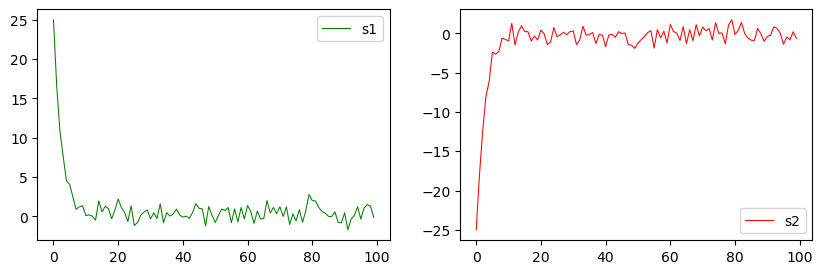

1.097191438726779
-0.9511088754067495


<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.172

In [6]:
n_samples = 100
burn = 0
s_init = [25,-25]
s1, s2 = gibbs(y, mu_a, A, b, sigma_a, sigma_ba, n_samples, burn, s_init)

vsPlot(s1, 's1', s2, 's2')


print(np.mean(s1))
print(np.mean(s2))
az.rhat(az.convert_to_dataset(np.array([s1, s2])))

# Looking at graph, choose burn in around 10

## Confirm burn-in performance

In [7]:
az.rhat(az.convert_to_dataset(np.array([s1[10:], s2[10:]])))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.078